
## Project Topic

For my final project I have chosen a topic related to research that I have done for the company that I work for, ProtonVDA LLC. ProtonVDA has developed a proton imaging system, a new medical imaging device which makes images of cancer patients using protons rather than X-rays or other standard methods. The system detects one proton at a time from a beam with a known energy, measuring its trajectory through the patient and its energy loss, and combines millions of these data points to reconstruct an image, as shown in the figure below: 
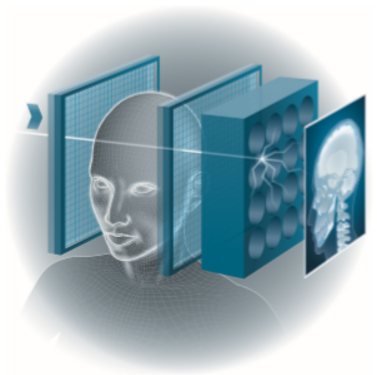

The system consists of an upstream tracking detector, which measures the positions of individual protons entering the patient, a downstream tracking detector, which measures the positions exiting the patient, and an energy detector, which measures the remaining energy of the proton after it exits the patient. 

The tracking detectors are made of two layers of 1-mm thick scintillating fibers, arranged horizontally and vertically to detect X and Y coordinates. When a proton passes through a fiber, it generates a signal which is detected by a photosensor. There are 384 fibers in each direction, but (for reduced complexity) only 32 sensors. The fibers are divided into 12 "strips" of 32, with every 32nd fiber channeled into the same sensor. Therefore, given a channel number X from 0-31 and a channel number Y from 0-31, there are 12 possible locations for both X and Y. This ambiguity can be resolved by obtaining the approximate position of the proton based on knowledge of where the beam is directed at that time. One example is illustrated below. For a proton with X and Y channel numbers of (16, 14), the possible positions in X are fiber indices 16, 48, 80, 112, 144, 176, 208, 240, 272, 304, 336, and 368, while the possible positions in Y are 14, 46, 78, 110, 142, 174, 206, 238, 270, 302, 334, and 366. Knowing that the beam is approximately aimed at point (245, 245), the coordinates (240, 238) are selected. 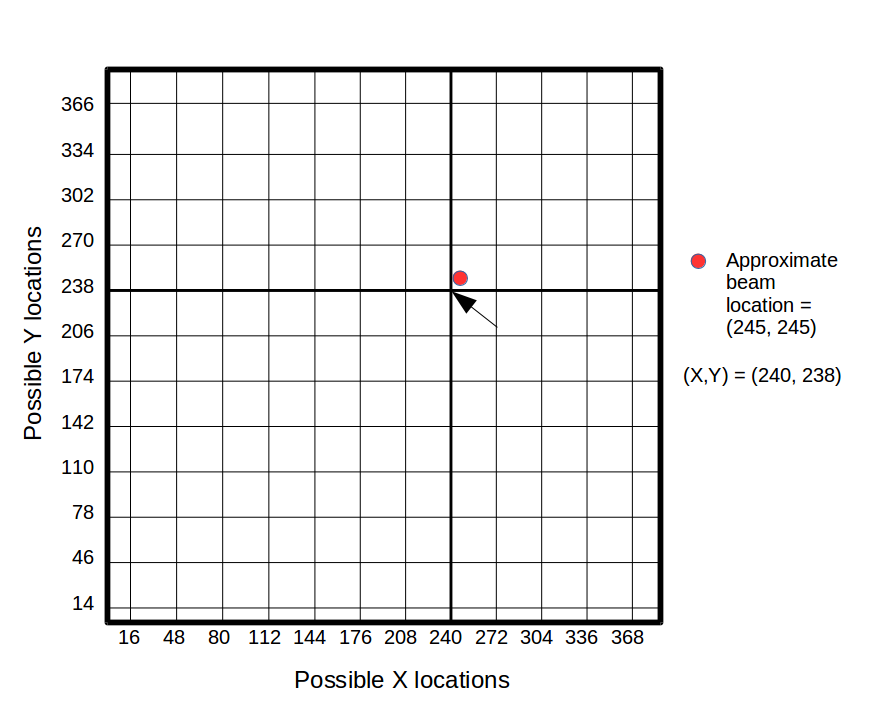

What if this knowledge of the approximate beam location is unavailable? Some beam configurations launch protons to random positions over a wide area, in which case this method would be useless. The goal of my project is use machine learning to find the correct positions for the protons using data from both the tracking detectors and the energy detector.

The energy detector is a single block of plastic scintillator with 16 photomultiplier tubes (PMT's) attached to the back, which are the circles in the first figure. When a proton enters the detector, it produces an amount of light that is proportional to its energy, and this light is measured by the PMT's. The magnitude of the signal produced by each PMT depends on the position of the proton as well as its energy. The output of the energy detector is given by 4 variables: E, U, V, and C, which are different weighted sums of the PMT signals. E is a sum of all the PMT's, while U, V, and C are weighed by position. The weights are shown below: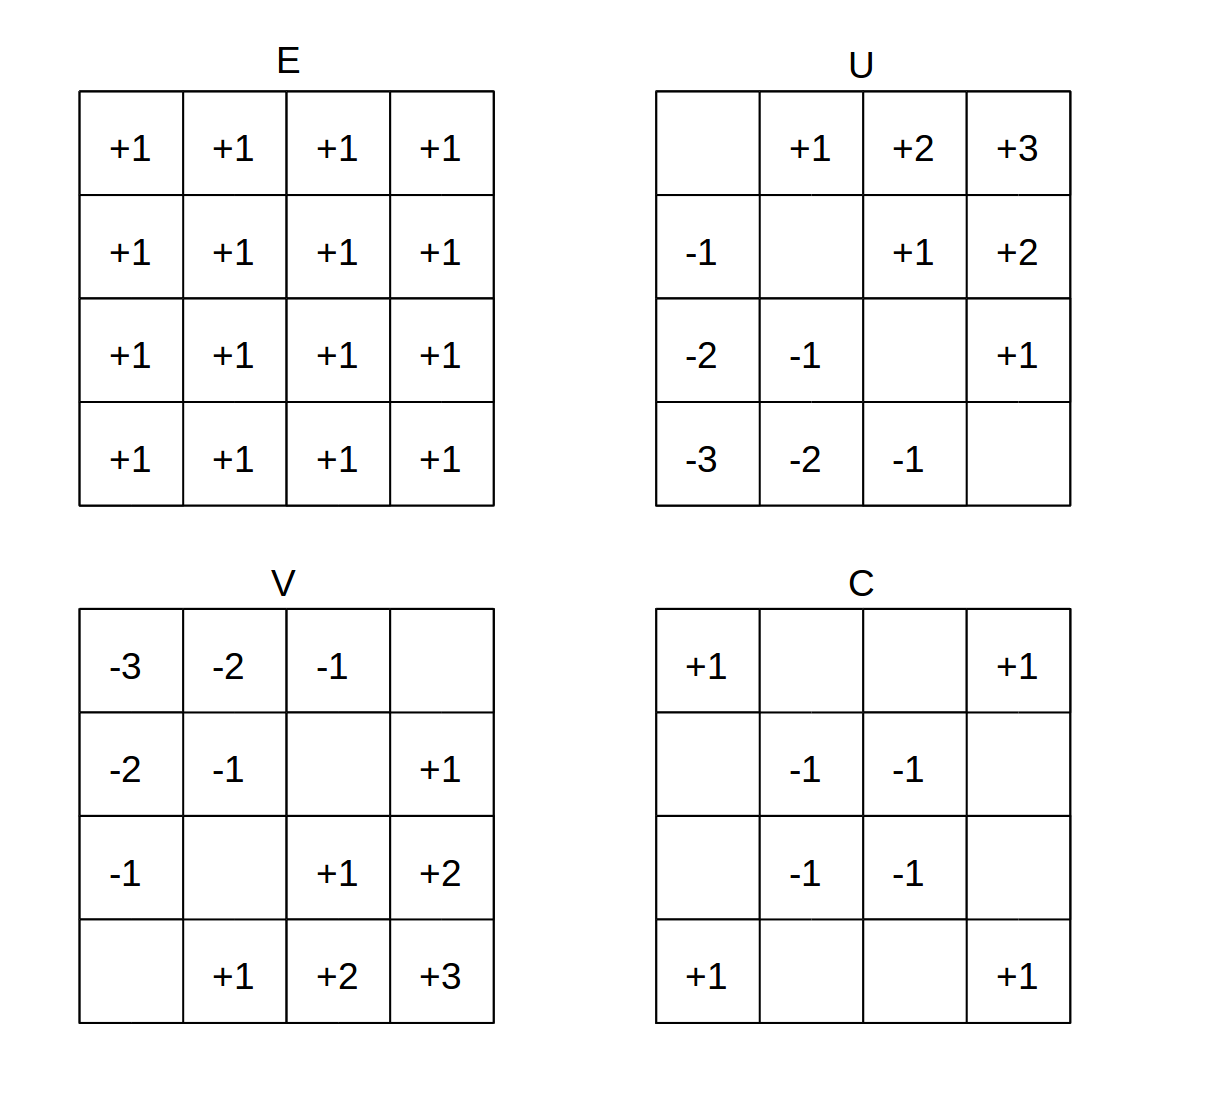

Using these 4 outputs E, U, V, C as features, along with channel numbers XU, YU, XD, and YD (x-upstream, y-upstream, x-downstream, y-downstream), I will build a **supervised learning** model to determine the correct positions of the protons. This is a **classification** problem, as for a given channel number, there are 12 possible positions. The model can be performed separately for each of the 32 channel numbers for each position variable (although once the downstream positions are determined, the upstream positions can easily be inferred from tracing the path of the proton back to the source). For this particular project, I will look at a dataset of protons with XD = 15, and attempt to classify their positons in terms of Strip number, labeled 1-12.

In [18]:
#Load relevant libraries

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

### Data Cleaning and Preparation

The raw proton data comes as a list of 9 features for each proton: the four tracking detector signals (XU, YU, XD, YD), four energy detector signals (E, U, V, C), and a timestamp. It takes millions of protons to reconstruct an image, and the files can reach gigabytes in size. I have uploaded a random sample of size 4 MB below. These data were provided to me by ProtonVDA and I have uploaded them to Github.

In [19]:
df = pd.read_csv("https://raw.githubusercontent.com/edejongh1/Supervised-Learning-Final-Project/main/rawdata.txt")
df = df.sample(frac=0.1, random_state=1)
df.head(20)

,timestamp,E,U,V,C,XU,YU,XD,YD
55167,10852.897060,-7058,3623,561,-92,2097152,64,4,2147483648
7344,10822.107478,-3815,-1118,-1242,55,536870912,12,8,16
64109,10858.684692,-1981,5,1334,-352,32768,64,0,134217728
26378,10834.375210,-6524,1264,-3077,38,16384,4,160,262144
39148,10842.578666,-6854,-1197,2057,570,128,1024,1024,8388608
14761,10826.891850,-5827,-132,-3781,-667,16777216,49152,32,3
51602,10850.598657,-5322,3281,-435,-470,2147483648,24576,65536,67108864
59276,10855.552572,-3911,2671,-147,-572,1073741824,0,524288,64
17147,10828.428831,-6926,-2452,-1022,428,268435456,536870912,4096,2
59802,10855.893652,-6061,2096,1888,209,8,8,131072,24


The timestamp feature represents seconds since an arbitrary start time. It is used to correlate the protons with the position of the beam when it is known. For input to the supervised learning model, this column can be dropped.

The E, U, V, and C signals are repersented as signed integers. The unweighted sum E is negative by default, but I prefer to make it positive to more intuitively visualize its magnitude during exploratory data analysis.

The tracking detector signals are represented as 32-bit unsigned integers which encode the sum of all activated channels using powers of 2. For example, if a signal is detected in channels 5 and 6, the output is 2^5 + 2^6 = 32 + 64 = 96. A normal proton event will pass through either a single channel or two adjacent channels for each of the four tracking variables. If more channels are activated, or if two non-adjacent channels are activated, the event must be discarded. This usually occurs when multiple protons arrive at once, and these data aren't useful. We must also discard events which have zero channels activated for one or more of the tracking variables. These are either electronic noise events or cosmic particles hitting the energy detector. 

The first step in cleaning the data is to decode the tracking signals and determine whether they are good or bad events. Good events should be simplified to a number from 0-31 representing the fiber channel number. This is done in the code below.

In [20]:
#Function to determine channel number from 0-31. Invalid data are labeled -1.
def decode(channels):
    if channels == 0:
        return -1 
        #No channels = bad event
    
    highest = int(math.log(channels, 2)) #highest channel encoded
    rem = channels % 2**highest 
    if rem == 0:
        return highest 
        #single channel encoded
    
    lowest = int(math.log(rem, 2)) #next-highest channel encoded
    rem = rem % 2**lowest
    if rem > 0:
        return -1 
        #More than two channels = bad event
    
    diff = highest - lowest
    if diff == 1 or diff == 31: #Channels are adjacent (0 and 31 are adjacent at strip boundary)
        return lowest 
        #Return the lower of the two channels
    else:
        return -1 
        #Non-adjacent channels = bad event

def clean_df(df):
    
    N = df.shape[0]
    df_clean = df.drop(['timestamp'], axis=1)   
    
    for i in range(N):
        df_clean.iloc[i]['XU'] = decode(df.iloc[i]['XU'])
        df_clean.iloc[i]['YU'] = decode(df.iloc[i]['YU'])
        df_clean.iloc[i]['XD'] = decode(df.iloc[i]['XD'])
        df_clean.iloc[i]['YD'] = decode(df.iloc[i]['YD'])
        df_clean.iloc[i]['E'] = -1*df.iloc[i]['E'] #Flip sign of E
   
    #Drop rows with values of -1 for any tracking variable
    df_clean = df_clean[df_clean['XU'] > -1][df_clean['YU'] > -1][df_clean['XD'] > -1][df_clean['YD'] > -1]
    return df_clean

df_clean = clean_df(df)
df_clean.head(20)

,E,U,V,C,XU,YU,XD,YD
55167,7058,3623,561,-92,21,6,2,31
7344,3815,-1118,-1242,55,29,2,3,4
39148,6854,-1197,2057,570,7,10,10,23
14761,5827,-132,-3781,-667,24,14,5,0
51602,5322,3281,-435,-470,31,13,16,26
17147,6926,-2452,-1022,428,28,29,12,1
59802,6061,2096,1888,209,3,3,17,3
35505,7796,-313,235,1541,3,21,2,24
34949,6458,-2703,1592,155,22,5,16,18
31140,4667,-1956,1094,34,28,10,21,29


Further data cleaning is usually done after the true fiber positions from 0-383 are determined using the timestamp-based method. This involves removing outliers in E, U, V, and C by binning protons according to their XD and YD positions and iteratively removing EUVC values more than 3 standard deviations from the mean. I have done this offline and uploaded a separate clean dataset below. This will be the training data for my supervised learning model.

Each of the protons in this dataset has an x-downstream channel number of 15 (XD = 15), and the goal is classify it by strip number 1-12. These labels correspond to the possible x-downstream fiber indices of 15, 47, 79, etc. Each entry in the dataset therefore has 7 training features: "E","U","V","C","XU_FIBER","YU_FIBER","YD_FIBER", and one training label "Strip". I chose a random sample of 100,000 protons with a uniform spread in position and energy, contained in a csv file of about 2.7 MB.

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/edejongh1/Supervised-Learning-Final-Project/main/CleanData.csv")
df = df.sample(frac=1, random_state=1)
print(df.head(20))
df.describe()

          E     U     V     C  XU_FIBER  YU_FIBER  YD_FIBER  Strip
5378    445  -161   -49    26        25        19         0     12
61752  2382  -211 -1351   175        23        10        30     12
29139  1529    17  -800    87        28         2        21     11
9736    673    30  -315    40        27        28        11     11
45252  3868  -271 -1276  -192         1        17        11      9
25600  2116  -162   847   -26        24        17        29      4
63687  4397  -211 -2026   150        28        29        14     10
17623  1590   654   232   -34         6        11         8      2
3714    626   -19   268   -24         0         8        27      3
39632  3812  1101   347  -236        27        28        24      4
27816  2112   791   -95   -33        26        26        12      4
28641  3118  -497   -86  -268        13        18        21      8
73438  5819 -1835 -1360  -331         2         8         9     10
69628  3657  1914  -382   220         0        27         3   

,E,U,V,C,XU_FIBER,YU_FIBER,YD_FIBER,Strip
count,98991.000000,98991.000000,98991.000000,98991.000000,98991.000000,98991.000000,98991.000000,98991.000000
mean,3529.312786,-54.992222,38.292663,-94.261418,15.178158,15.616177,15.678637,6.571476
std,2122.067348,1224.854251,1209.449332,376.317720,9.836031,9.285779,9.210358,3.484467
min,82.000000,-6236.000000,-5669.000000,-2116.000000,0.000000,0.000000,0.000000,1.000000
25%,1856.000000,-640.000000,-544.000000,-195.000000,6.000000,7.000000,8.000000,4.000000
50%,3060.000000,-33.000000,15.000000,-29.000000,14.000000,15.000000,16.000000,7.000000
75%,4988.000000,531.000000,615.000000,63.000000,24.000000,24.000000,24.000000,10.000000
max,10684.000000,6014.000000,5927.000000,1695.000000,31.000000,31.000000,31.000000,12.000000


### Exploratory Data Analysis

The first step in my analysis of the data is to create a pair plot to examine the relationships between the features.

<Figure size 936x720 with 0 Axes>

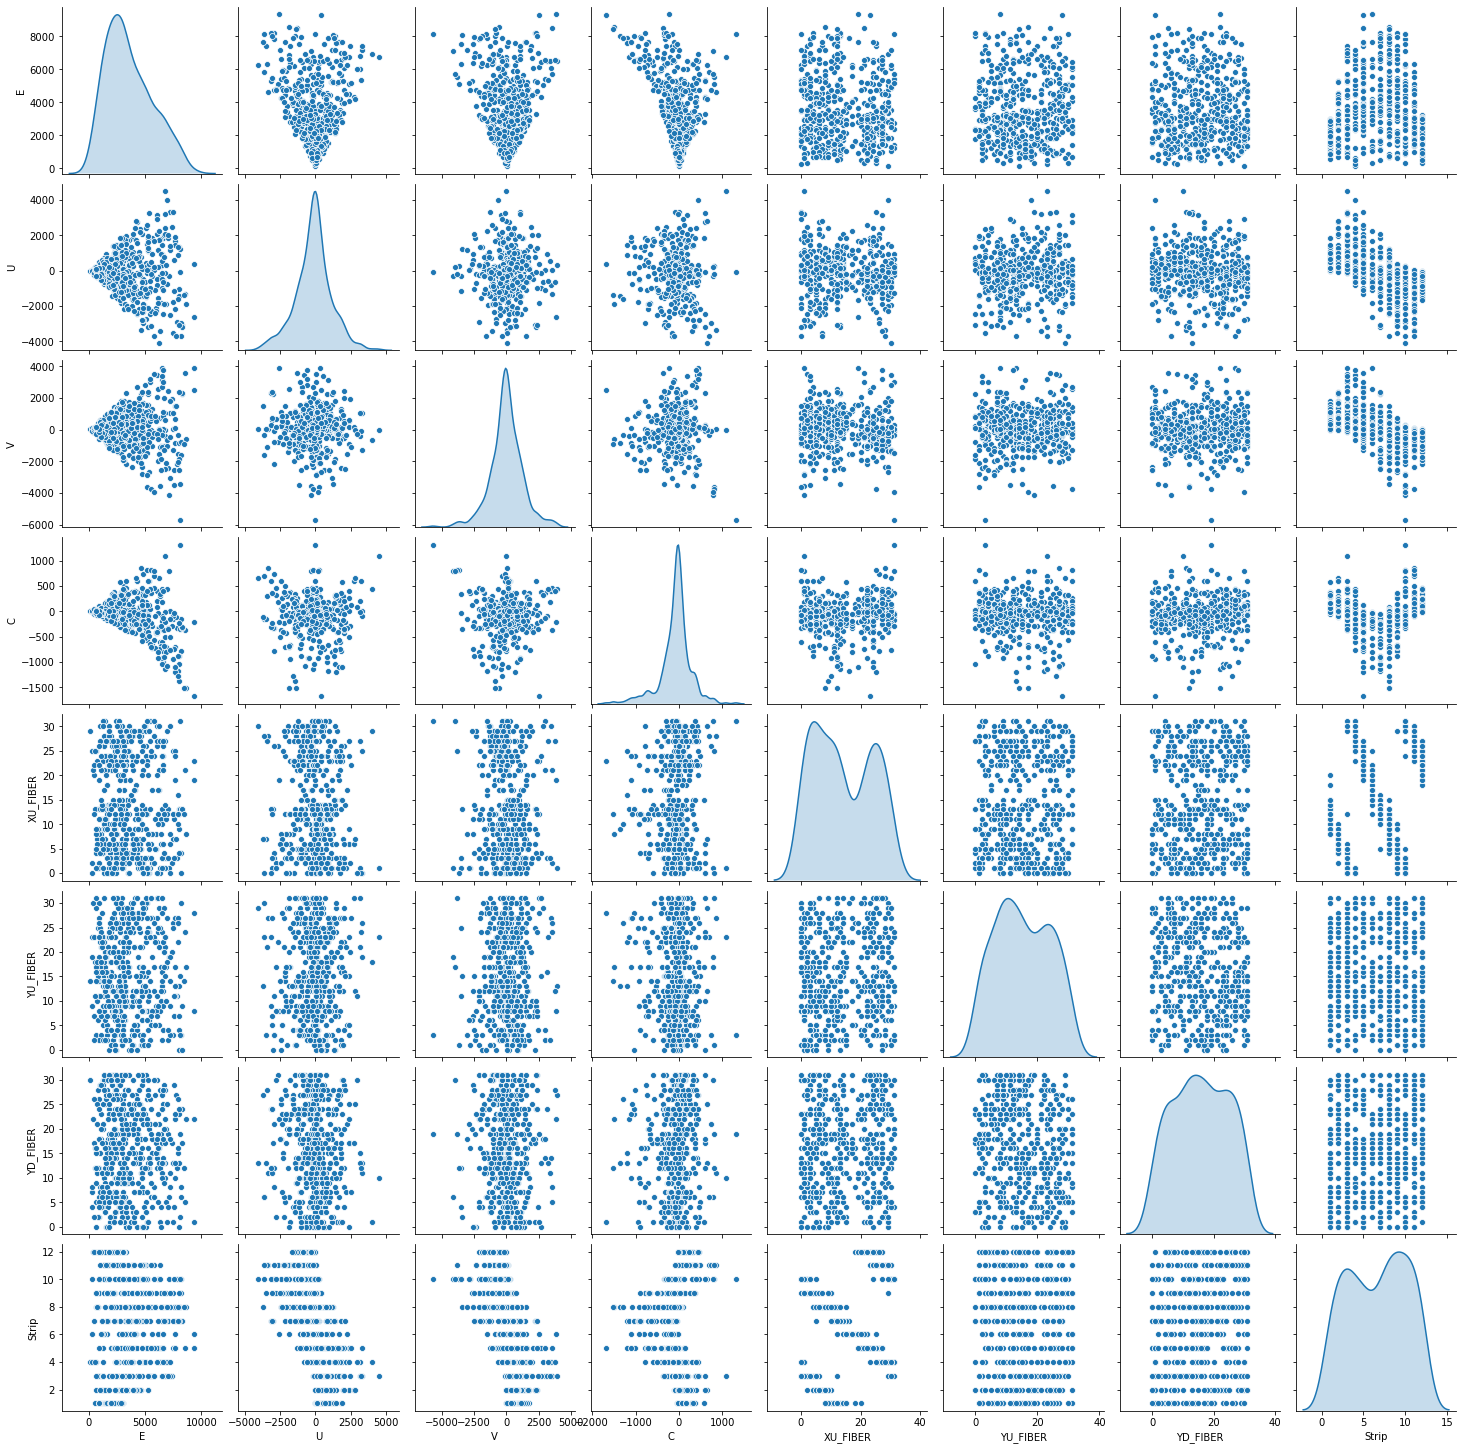

In [6]:
plt.figure(figsize=(13, 10))
sns.pairplot(df.sample(n=500),diag_kind='kde')
plt.show()

The pair plot reveals several useful insights. The variables U and V appear negatively correlated with the strip number. The strip number also has non-linear relationships with E, C, and XU_FIBER. There doesn't seem to be any tangible relationship to YU_FIBER or YD_FIBER. The relationships between E and U, V, and C are also notable. They are not correlated in a particular direction, but the magnitudes are correlated.

Next, I will make a correlation matrix:

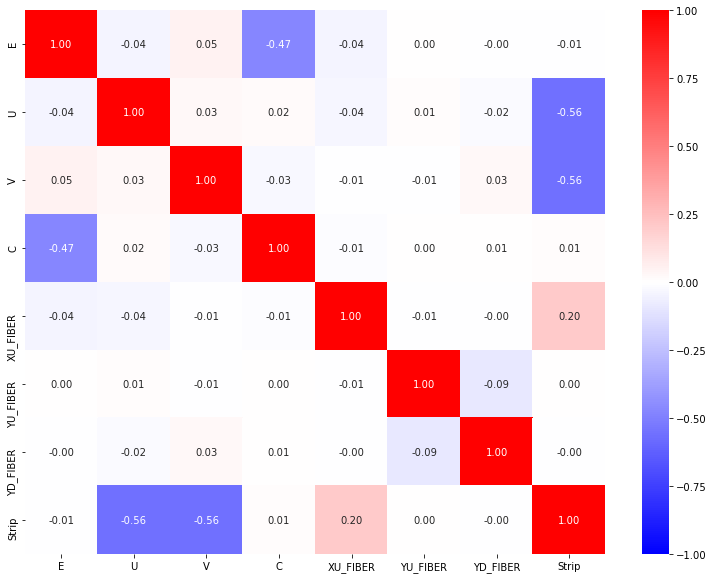

In [7]:


plt.figure(figsize=(13, 10))
sns.heatmap(df.corr(),annot=True,fmt=".2f",vmin=-1,vmax=1,cmap='bwr')

The correlation matrix reveals a strong negative correlation between U and V and the strip number, as well as a slight positive correlation with XU_FIBER. From these results, it may be tempting to conclude that U and V, and perhaps XU_FIBER are the only variables that matter when predicting the strip number. However, as the pair plot has revealed, variables that aren't correlated can still be dependent on each other. In particular, the magnitudes of U and V necessarily depend on the magnitude of E, since they are different weighted sums of the same signals. U and V alone cannot predict the position of a proton, because higher energy protons will produce higher magnitude U and V signals for the same position.

I am going to explore the relationships between E, U, V, and strip number using scatterplots. Below I have defined a function that retrieves the U and V values for a given strip and a given range of E values. The first scatterplot plots U and V for three different strips across the entire range of E values.

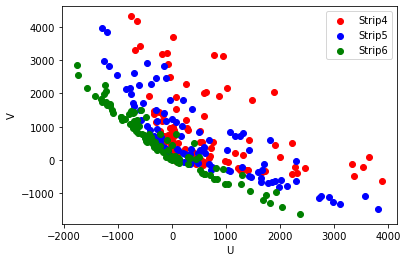

In [8]:
def GetUV(df, strip, n_samples, E_min, E_max):
    
    df_tmp = df[df['Strip'] == strip][df['E'] >= E_min][df['E'] <= E_max].sample(n=n_samples)
    U = df_tmp[['U']]
    V = df_tmp[['V']]
    return U, V

n = 100
E_min = 0
E_max = 10000

X4, Y4 = GetUV(df, 4, n, E_min, E_max)
X5, Y5 = GetUV(df, 5, n, E_min, E_max)
X6, Y6 = GetUV(df, 6, n, E_min, E_max)

S4 = plt.scatter(X4,Y4,color='red')
S5 = plt.scatter(X5,Y5,color='blue')
S6 = plt.scatter(X6,Y6,color='green')
plt.legend((S4, S5, S6),("Strip4","Strip5","Strip6"))
plt.xlabel("U")
plt.ylabel("V")
plt.show()

From this scatterplot, it looks difficult to classify the strip number based on U and V alone. However, when I plot U and V for a narrow range of E, the points appear to separable regions for the strips. Below are three different plots for three different ranges of E: (1000-1200, 2000-2200, and 3000-3200). Clearly, all three of E, U, and V need to be included in the model.

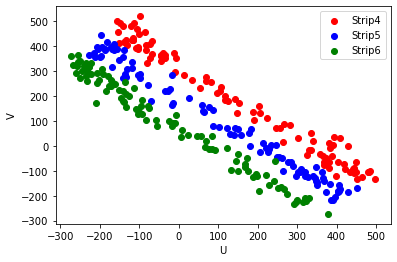

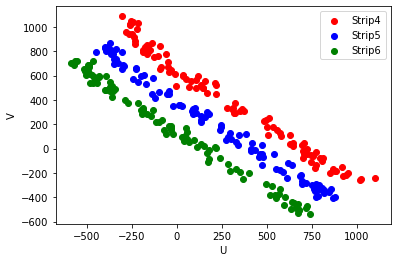

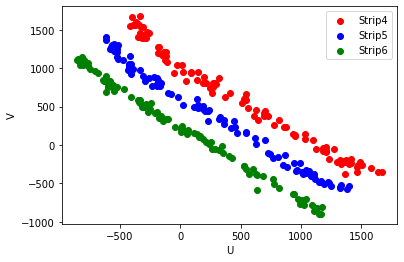

In [9]:
E_min = 1000
E_max = 1200

X4, Y4 = GetUV(df, 4, n, E_min, E_max)
X5, Y5 = GetUV(df, 5, n, E_min, E_max)
X6, Y6 = GetUV(df, 6, n, E_min, E_max)

S4 = plt.scatter(X4,Y4,color='red')
S5 = plt.scatter(X5,Y5,color='blue')
S6 = plt.scatter(X6,Y6,color='green')
plt.legend((S4, S5, S6),("Strip4","Strip5","Strip6"))
plt.xlabel("U")
plt.ylabel("V")
plt.show()

E_min = 2000
E_max = 2200

X4, Y4 = GetUV(df, 4, n, E_min, E_max)
X5, Y5 = GetUV(df, 5, n, E_min, E_max)
X6, Y6 = GetUV(df, 6, n, E_min, E_max)

S4 = plt.scatter(X4,Y4,color='red')
S5 = plt.scatter(X5,Y5,color='blue')
S6 = plt.scatter(X6,Y6,color='green')
plt.legend((S4, S5, S6),("Strip4","Strip5","Strip6"))
plt.xlabel("U")
plt.ylabel("V")
plt.show()

E_min = 3000
E_max = 3200

X4, Y4 = GetUV(df, 4, n, E_min, E_max)
X5, Y5 = GetUV(df, 5, n, E_min, E_max)
X6, Y6 = GetUV(df, 6, n, E_min, E_max)

S4 = plt.scatter(X4,Y4,color='red')
S5 = plt.scatter(X5,Y5,color='blue')
S6 = plt.scatter(X6,Y6,color='green')
plt.legend((S4, S5, S6),("Strip4","Strip5","Strip6"))
plt.xlabel("U")
plt.ylabel("V")
plt.show()

### Model Selection and Evaluation

Based on the results of the scatterplots above, I believe that a simple k-Nearest-Neighbor (KNN) model will be a good choice for this classification problem. The data points from different strips appear to cluster in separable regions. A linear regression model would be difficult to fit because of the non-linear interactions between variables. A decision-tree model could work, but due to the data having a relatively high number of labels (12) compared to features (7), such a model would be prone to overfitting and require extensive parameter tuning. KNN, by contrast, has only one main hyperparameter K to tune. In addition, all of the features can be represented as continuous variables, which is ideal for KNN.

In order to make this model work, I first need to normalize the training variables. The code below rescales the variables to values between 0 and 1 based on the minimum and maximum in the sample.

In [10]:
df_X = df[['E','U','V','C','XU_FIBER','YU_FIBER','YD_FIBER']]

scaler = MinMaxScaler()
scaler.fit(df_X)

X = scaler.transform(df_X) #Normalized input variables
y = df['Strip'].tolist() #List of target labels
X

array([[0.03423882, 0.49591837, 0.48464988, ..., 0.80645161, 0.61290323,
        0.        ],
       [0.2169402 , 0.49183673, 0.37236978, ..., 0.74193548, 0.32258065,
        0.96774194],
       [0.13648368, 0.51044898, 0.41988617, ..., 0.90322581, 0.06451613,
        0.67741935],
       ...,
       [0.03489908, 0.49134694, 0.48654709, ..., 0.87096774, 1.        ,
        0.5483871 ],
       [0.69958498, 0.37216327, 0.57390479, ..., 0.4516129 , 0.80645161,
        0.93548387],
       [0.74335031, 0.17681633, 0.65332873, ..., 0.25806452, 0.64516129,
        0.35483871]])

I will start by using scikit-learn's built-in KNN classifier with the default parameter k = 5. For this first test, I am including all 7 features in the model. I use the train_test_split function to make a training set from 80% of the data and a test set from the remaining 20%. The resulting classification accuracy is shown below.

In [11]:
#Function to calculate the percentage of correctly-classified samples
def Get_acc(y_test, y_pred):
    N = len(y_test)
    count = 0
    for i in range(N):
        if(y_test[i] == y_pred[i]):
            count = count + 1
            
    return count/N

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X_train,y_train)
y_pred = knc.predict(X_test)
print("Accuracy = ",Get_acc(y_test,y_pred))

Accuracy =  0.7720591949088338


The first model resulted in an accuracy of about 77%, which seems disappointing based on how separable the data looked in the exploratory scatter plots. To further analyze the results, I will create a confusion matrix to see which strips are most often misclassified.

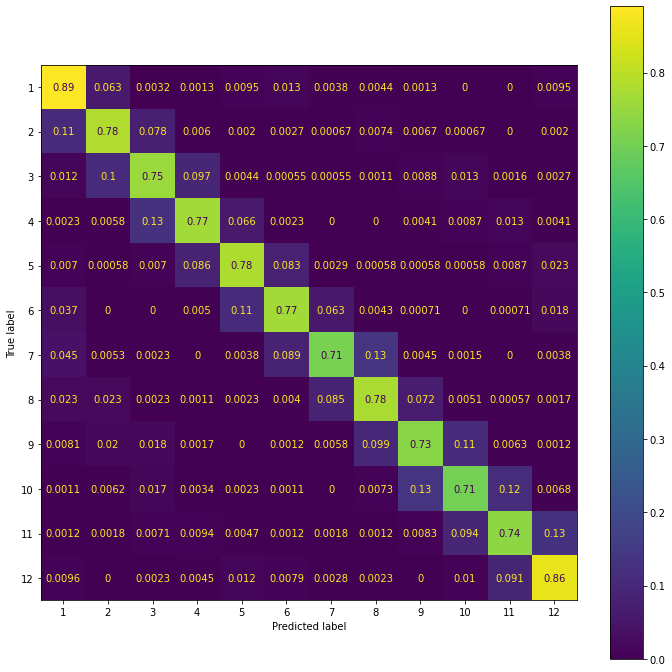

In [12]:
cfm = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(cfm,display_labels=[1,2,3,4,5,6,7,8,9,10,11,12])

fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show()

This confusion matrix indicates that labels are most often misclassified as an adjacent label. Since the strips on the edges have only one adjacent label, they are less likely to be misclassified. However, the most confusing result here might be the number of samples that are way off in their classification. For instance, more than 1% of true "3's" are classified as "10's". This should almost never happen based on the strength of the correlations we have observed in exploratory data analysis.

I suspect that the model is suffering from the "curse of dimensionality" and overfitting by including too many variables. My next test will include only the E,U,V, and C variables:

In [13]:
#Remove the XU_FIBER, YU_FIBER, and YD_FIBER columns from the training and test sets
X_train_EUVC = np.delete(X_train, [4,5,6], axis=1)
X_test_EUVC = np.delete(X_test, [4,5,6], axis=1)

knc.fit(X_train_EUVC, y_train)
y_pred_EUVC = knc.predict(X_test_EUVC)
print("EUVC model Accuracy = ",Get_acc(y_test,y_pred_EUVC))

EUVC model Accuracy =  0.9387847871104601


This result (94%) is indeed much better. Next, I will try models with one more variable removed and one more added.

In [14]:
#Remove the C, XU_FIBER, YU_FIBER, and YD_FIBER columns from the training and test sets
X_train_EUV = np.delete(X_train, [3,4,5,6], axis=1)
X_test_EUV = np.delete(X_test, [3,4,5,6], axis=1)

knc.fit(X_train_EUV, y_train)
y_pred_EUV = knc.predict(X_test_EUV)
print("EUV model Accuracy = ",Get_acc(y_test,y_pred_EUV))

#Remove the YU_FIBER, and YD_FIBER columns from the training and test sets
X_train_EUVCxu = np.delete(X_train, [5,6], axis=1)
X_test_EUVCxu = np.delete(X_test, [5,6], axis=1)

knc.fit(X_train_EUVCxu, y_train)
y_pred_EUVCxu= knc.predict(X_test_EUVCxu)
print("EUVCxu model Accuracy = ",Get_acc(y_test,y_pred_EUVCxu))

EUV model Accuracy =  0.938380726299308
EUVCxu model Accuracy =  0.891661195009849


There is essentially zero difference in accuracy between the EUV-only model and the EUVC model. However, adding in the XU_FIBER variable significantly reduces the accuracy (86%). This is somewhat surprising, since there was a noticable correlation between XU_FIBER and strip number. On further examination of the pair plot, it appears that while XU_FIBER helps narrows down the possible strip values, it may not be useful in distinguishing between nearby strips. 

For the sake of simplicity, it makes sense to use the EUV-only model instead of EUVC, given that they achieve similar results. In order to further refine the model, I will try a range of values for K and use 5-fold cross-validation to generate an accuracy score for each. The results are plotted below:

1 0.93483247112315
2 0.930387624130441
3 0.9382873175953742
4 0.9388227190895533
5 0.9409037113525327
6 0.9400450438616348
7 0.9410148413415621
8 0.9406410702945959
9 0.9406410682536785
10 0.9405703489378283
11 0.9403279007158624
12 0.9394086343078782
13 0.939913735833285
14 0.9391965013615649
15 0.9390954739132729
16 0.9383479425341562
17 0.9385095663483878
18 0.9376812136229129
19 0.9379034480895052
20 0.9368932542228199


Text(0, 0.5, 'Accuracy')

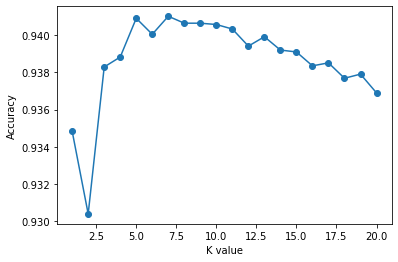

In [15]:
K_range = range(1,21)
acc = []

#Prepare EUV-only input
X_EUV = np.delete(X, [4,5,6], axis=1)

#Loop over K values from 1 to 20
for k in K_range:
    knc = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knc,X_EUV,y,cv=5) #perform 5-fold cross validation
    acc.append(np.mean(scores)) #record the average accuracy from the 5 tests
    print(k, np.mean(scores))
    
plt.plot(K_range,acc,'-o')
plt.xlabel("K value")
plt.ylabel("Accuracy")

This plot shows maximum accuracy is achieved with of K value of 7, but there is very little difference from 5 until about 13 or so. I would choose a parameter value of K = 10 for the model in order to have a good balance of bias and variance.

Finally, I will plot a new confusion matrix to analyze the results of the final model.

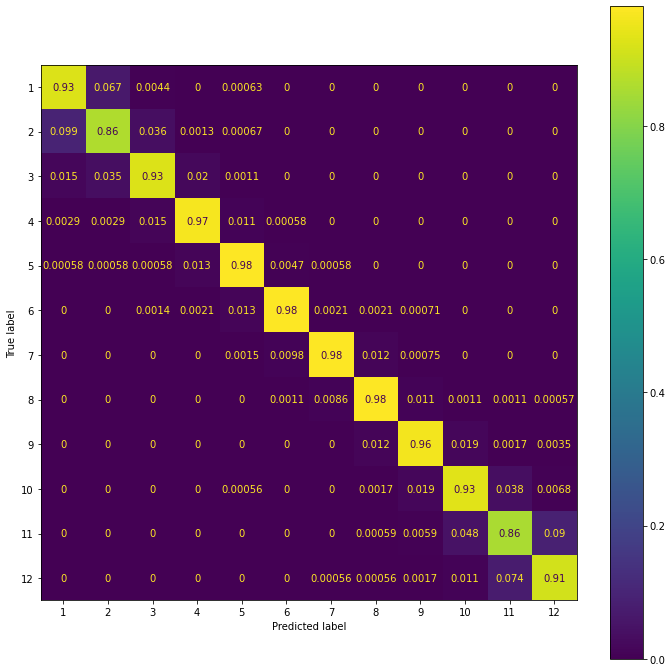

In [16]:
cfm = sklearn.metrics.confusion_matrix(y_test, y_pred_EUV, normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(cfm,display_labels=[1,2,3,4,5,6,7,8,9,10,11,12])

fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show()

This confusion matrix shows that the 94% accuracy of the model is not universal. It is around 98% for the middle group of strips and as low as 86% for the outer strips. The most frequently confused pairs of strips are 1-2 and 11-12. The reason for this is likely related to the signal-to-noise ratio of the energy detector. We see from the pair plot that the magnitudes of E,U,V, and C decline near the outer strips, which means that the ranges of values for each strip are closer together and more likely to overlap due to noise.

### Discussion and Conclusion

In this project, I have demonstrated that a k-Nearest-Neighbors supervised learning model can be used to correctly classify the positions of protons and resolve the ambiguity in the tracking detector output for the ProtonVDA proton imaging system. The model accuracy is not perfect, but it is adequate enough such that any misclassified events will likely be filtered out as outliers in subsequent data cleaning procedures. The 98% accuracy for the middle strips means that the model is particularly useful for classifying data from small images that don't require using the entire surface area of the detectors.

An interesting result of this project is that the highest accuracy was achieved using just three features for inputs to the model. One would think that, all else being equal, incorporating more available information would improve the model. The results to the contrary demonstrate the risks of overfitting. For the KNN model, it is particularly detrimental to include features such as YU_FIBER and YD_FIBER with no apparent relationship to the output variable and give them the same weight as the more predictive features such as E, U, and V. The model might be improved by giving more or less weight to certain features when determining the distance for KNN. The C and XU_FIBER variables appear to have some predictive value based on exploratory analysis, so perhaps including them with small, properly tuned weights could produce better results.

The scope of this project was somewhat limited in that I chose to focus on classifing a particular subset of data for which the XD fiber channel output was 15, and I am assuming that the algorithm will work similarly well for all XD channels and YD channels. One possible way to improve the model is to broaden its scope so that it classifies pairs of XD and YD channels, with 12 x 12 = 144 possible labels. This could potentially work better than classifing XD and YD separately, because the parameters of the training data would more closely match the input data. However, the training dataset would have to be much larger to avoid overfitting to small samples for each label.

### Link to Github Repository: https://github.com/edejongh1/Supervised-Learning-Final-Project/tree/main

### ProtonVDA Citation: https://arxiv.org/abs/2009.04652
DeJongh, Ethan A., et al. "A fast and monolithic prototype clinical proton radiography system optimized for pencil beam scanning." Medical physics 48.3 (2021): 1356-1364.